In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
from constants import regions

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#Import sklearn modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### Create Features dataframe (df_ratios)

In [2]:
sys.argv[1] = 4
sys.argv[2] = 4

reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (6, 0.5), (8, 0.5), (10, 1), (12, 1), (14, 1)]
super_reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (4, 1), (6, 1), (8, 1), (10,1), (14, 1) ] 

In [3]:
# d_num = int( sys.argv[1] ), I never use this, originally I used this 
data_type = ['N2', 'N3','REM', 'Wake', 'N1'][3]


expt_num = 2

#2. Load the data based on data type ___________________________________________________________
df = pd.read_hdf(os.path.join(os.path.abspath('..'),'Multiple_PSDs_Per_Participant/' + data_type + 'processed_multiple_psds_per_person.h5') , key = 'df')

y = df['y'].copy()
groups = df['groups'].copy()

df = df.drop(columns = ['groups', 'y'])

regional_dfs = {}

for region in regions:
    
    single_region_df = df[[col for col in df.columns if col.endswith('_' + region)]]
    frequency_vals  = np.arange(0.5,40.125, 0.125)
    single_region_df.columns = frequency_vals
    
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    # paths = joblib.load(folder + data_type + '_paths.pkl')
    
    # groups = pd.Series(paths['s_p_id'])
    # s_class_list = pd.Series(paths['s_class_list'])
    # y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})
    
    #3 Generate the frequency band search space ____________________________________________________
    width_slide_list = [(0.5,0.5)] 
    for window_width in range(1, 15 ):
        width_slide_list.append((window_width, 0.5) )
    
    #4 Calculate all of the features ________________________________________________________________
    feature_dfs = []
    
    for window_width_hz, window_slide_hz in super_reduced_slide_list:
        description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
        
        #1.Set Window width in Hz and Window Slide in Hz
        # window_width_hz = 3
        window_len = (window_width_hz/0.125)+1
        assert window_len%1 == 0
        window_len = int(window_len)
        
        # window_slide_hz = 0.5 
        window_slide_len = window_slide_hz/0.125 
        assert window_slide_len%1 == 0
        window_slide_len = int(window_slide_len)
        
        
        #2.Calculate band values and store in dataframe calculated_df
        
        # Start of the window is the middle_freq value minus window_width_hz/2 
        # End of the window is the middle freq value plus window_width_hz/2
        window_len
        
        middle_freq = []
        final_cols = []
        
        i = 0
        while i < len(frequency_vals) - window_len:
            middle_freq.append( frequency_vals[i:i+window_len].mean() )
            band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
            
            final_cols.append(band_vals)
            
            # scaled_psd.append( psd_values[i:i+factor].mean() )
            i+= window_slide_len
        
        calculated_df = pd.DataFrame(final_cols).T
        calculated_df.columns = middle_freq
        
        calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
        
        
        #3.Calculate Information Gain Based on Features
        #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
        X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)
    
        feature_dfs.append(X_expt)
            
    #5 Concatenate all feature_dfs into a single dataframe_________________________________________________________________
    X_expt_concatenated = pd.concat(feature_dfs, axis=1)

    #6 Calculate Frequency Ratio Columns
    calculated_cols = []
    col_names = []
    
    X_expt_ratios = X_expt_concatenated.copy() 
    
    for col_1 in X_expt_concatenated.columns:
        for col_2 in X_expt_concatenated.columns:
            if col_1 == col_2:
                pass
            else:
                new_col = col_1 + '/' + col_2  
                col_names.append(new_col)
                calculated_cols.append( X_expt_concatenated[col_1]/X_expt_concatenated[col_2] )
    
    df_ratios = pd.concat(calculated_cols, axis = 1)
    df_ratios.columns = col_names
    df_ratios_and_freq = pd.concat([df_ratios, X_expt_concatenated], axis = 1)
    regional_dfs[region] = df_ratios_and_freq.copy()
    print(region + 'done!')

Prefrontaldone!
Frontaldone!
Left Frontaldone!
Right Frontaldone!
Centraldone!
Left Centraldone!
Right Centraldone!
Left Temporaldone!
Right Temporaldone!
Parietaldone!
Left Parietaldone!
Right Parietaldone!
Occipitaldone!


#### Select feature names from fitted DT

In [48]:
def nonzero_indices(arr):
    return [index for index, value in enumerate(arr) if value != 0]
    
cols_used_in_DT = [list(X_expt.columns)[i] for i in nonzero_indices(DT.feature_importances_)]

cols_used_in_DT

['13.0_width_1/7.5_width_4', '16.5_width_10/15.5_width_4', '4.5_width_8']

[Text(0.5, 0.8333333333333334, '4.5_width_8 <= 0.011\nentropy = 0.992\nsamples = 399\nvalue = [178, 221]'),
 Text(0.25, 0.5, '16.5_width_10/15.5_width_4 <= 0.848\nentropy = 0.791\nsamples = 257\nvalue = [61, 196]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.529\nsamples = 25\nvalue = [22, 3]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.653\nsamples = 232\nvalue = [39, 193]'),
 Text(0.75, 0.5, '13.0_width_1/7.5_width_4 <= 0.057\nentropy = 0.671\nsamples = 142\nvalue = [117, 25]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.485\nsamples = 19\nvalue = [2, 17]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.347\nsamples = 123\nvalue = [115, 8]')]

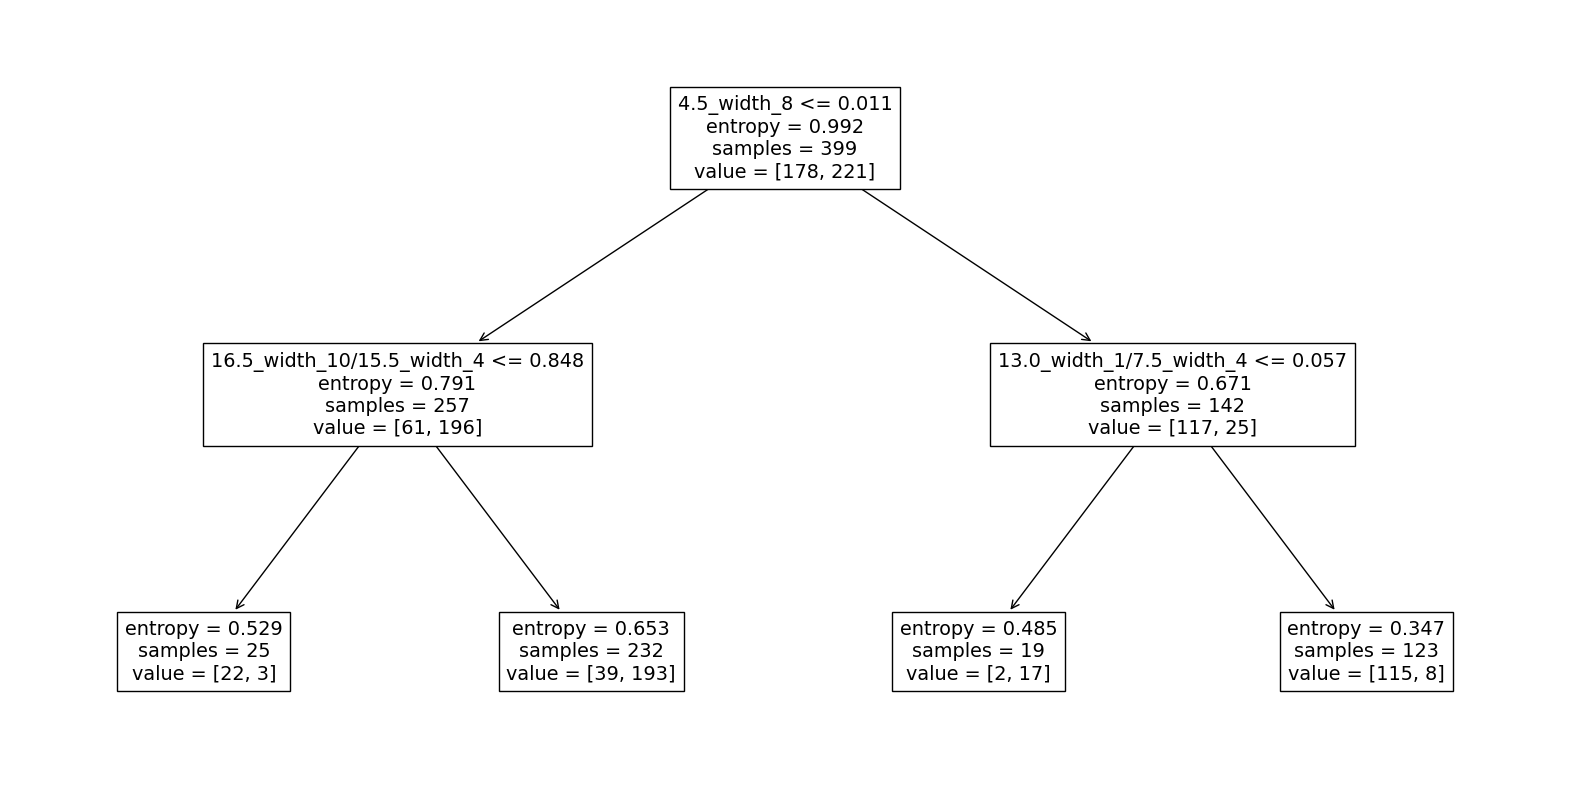

In [47]:
DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=4)
DT.fit(X_expt, y_expt)
plot_tree(DT, feature_names = list(X_expt.columns) )

#### Trial run using only the two feats from graph

0.008359909057617188


[Text(0.6666666666666666, 0.9, '1.5_width_2/6.5_width_6 <= 9.375\nentropy = 0.992\nsamples = 399\nvalue = [178, 221]'),
 Text(0.5555555555555556, 0.7, '32.5_width_1/7.5_width_1 <= 0.195\nentropy = 0.897\nsamples = 319\nvalue = [100, 219]'),
 Text(0.3333333333333333, 0.5, '1.5_width_2/6.5_width_6 <= 6.633\nentropy = 0.996\nsamples = 198\nvalue = [92, 106]'),
 Text(0.2222222222222222, 0.3, '1.5_width_2/6.5_width_6 <= 0.885\nentropy = 0.982\nsamples = 183\nvalue = [77, 106]'),
 Text(0.1111111111111111, 0.1, 'entropy = 0.619\nsamples = 13\nvalue = [11, 2]'),
 Text(0.3333333333333333, 0.1, 'entropy = 0.964\nsamples = 170\nvalue = [66, 104]'),
 Text(0.4444444444444444, 0.3, 'entropy = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(0.7777777777777778, 0.5, '1.5_width_2/6.5_width_6 <= 8.53\nentropy = 0.351\nsamples = 121\nvalue = [8, 113]'),
 Text(0.6666666666666666, 0.3, 'entropy = 0.179\nsamples = 111\nvalue = [3, 108]'),
 Text(0.8888888888888888, 0.3, 'entropy = 1.0\nsamples = 10\nvalue = [5, 

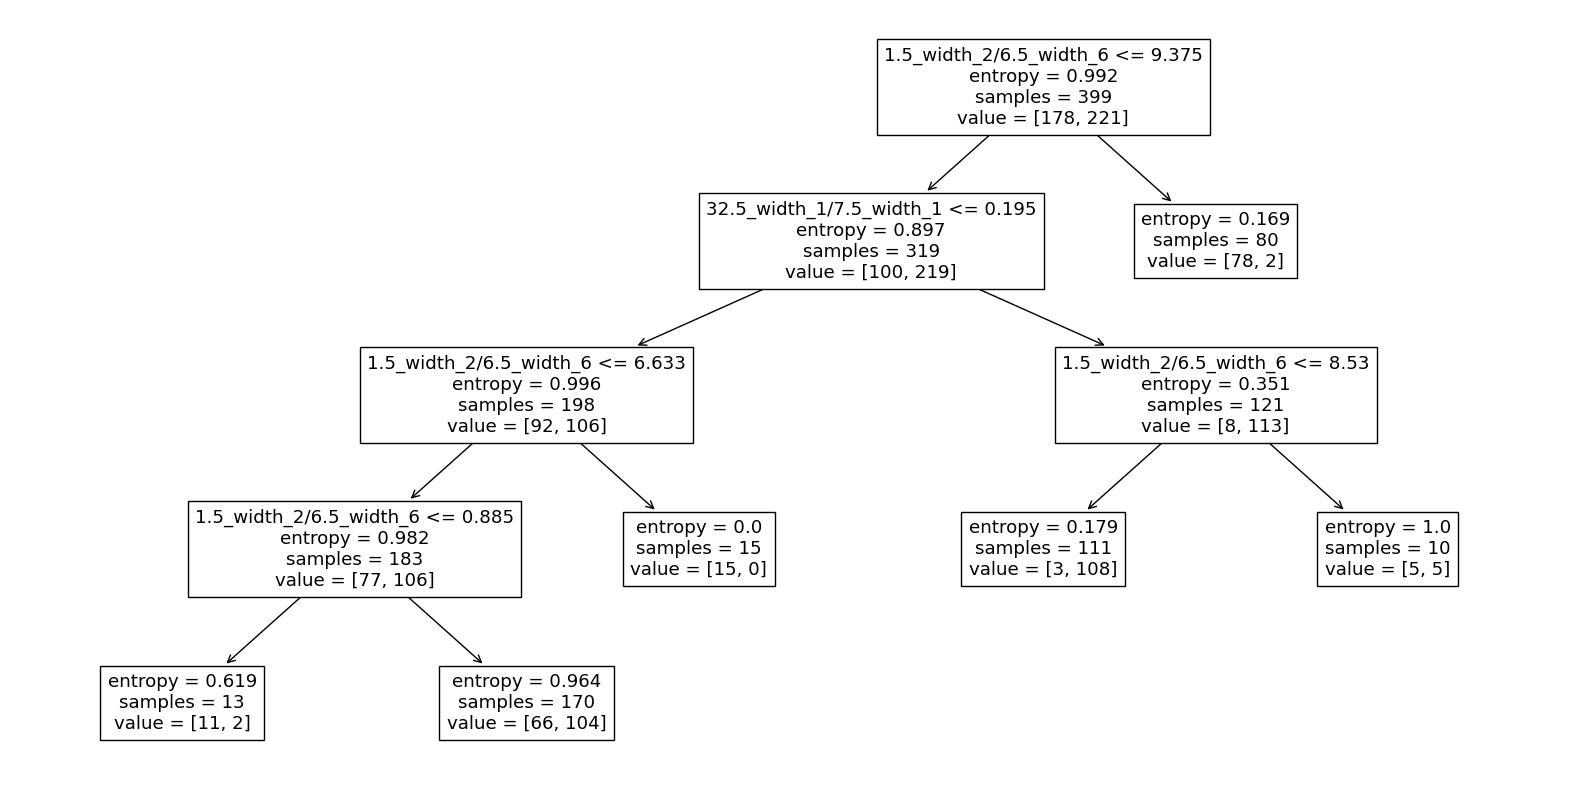

In [123]:
t1 = time.time()


X_two_feats = X_expt[ ['1.5_width_2/6.5_width_6','32.5_width_1/7.5_width_1'] ]

DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=6)
DT.fit(X_two_feats, y_expt)

t2 = time.time()

print(t2 -  t1 )

plot_tree(DT, feature_names = ['1.5_width_2/6.5_width_6','32.5_width_1/7.5_width_1'] )

In [128]:
DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 4)
DT.fit(X_expt[ ['1.5_width_2/6.5_width_6','32.5_width_1/7.5_width_1'] ] , y_expt)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=4)

In [111]:
DT = DecisionTreeClassifier()
DT.fit(X_expt[ ['1.5_width_2/6.5_width_6','32.5_width_1/7.5_width_1'] ] , y_expt)

DecisionTreeClassifier()

In [131]:
######### I want to plot the decision surface __________________________
min1, max1 = 0, 50 
min2, max2 = 0, 2

# define the x and y scale________________________
x1grid = np.arange(min1, max1, 0.01)
x2grid = np.arange(min2, max2, 0.01)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = DT.predict(grid)
# make predictions for the grid
yhat = DT.predict_proba(grid)
# keep just the probabilities for class 0
yhat = yhat[:, 0]

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
# plt.contourf(xx, yy, zz, cmap='Paired')

# plot the grid of x, y and z values as a surface
# c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
# plt.colorbar(c)

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [154]:
max_preds_arr = DT.predict_proba(X_expt[ ['1.5_width_2/6.5_width_6','32.5_width_1/7.5_width_1'] ]).max(axis = 1)
max_preds_arr[ max_preds_arr < 0.9 ]
X_expt[max_preds_arr < 0.9] 

,0.75_width_0.5/1.25_width_0.5,0.75_width_0.5/1.75_width_0.5,0.75_width_0.5/2.25_width_0.5,0.75_width_0.5/2.75_width_0.5,0.75_width_0.5/3.25_width_0.5,0.75_width_0.5/3.75_width_0.5,0.75_width_0.5/4.25_width_0.5,0.75_width_0.5/4.75_width_0.5,0.75_width_0.5/5.25_width_0.5,0.75_width_0.5/5.75_width_0.5,...,23.5_width_14,24.5_width_14,25.5_width_14,26.5_width_14,27.5_width_14,28.5_width_14,29.5_width_14,30.5_width_14,31.5_width_14,32.5_width_14
0,1.248938,3.656145,5.020548,3.826036,3.111625,6.019802,6.850840,13.199890,16.565399,15.327618,...,0.000619,0.000619,0.000614,0.000601,0.000574,0.000548,0.000529,0.000507,0.000486,0.000469
1,1.833459,1.570297,2.144887,1.469553,2.313344,4.533568,3.869839,6.592412,13.385934,10.207878,...,0.000967,0.001003,0.000940,0.000902,0.000877,0.000871,0.000883,0.000856,0.000835,0.000763
2,1.046547,0.673428,0.772460,0.989565,0.789065,1.584615,1.437882,4.700510,5.787341,4.848822,...,0.001057,0.000933,0.000921,0.000888,0.000875,0.000865,0.000802,0.000789,0.000759,0.000737
3,1.270927,1.440604,0.342864,0.240394,0.497908,1.596917,2.824054,1.416570,2.717521,3.205126,...,0.001149,0.001117,0.001057,0.000968,0.000895,0.000869,0.000830,0.000766,0.000737,0.000705
4,0.696394,0.738976,0.246915,0.343107,0.617792,1.351780,0.924378,0.906450,2.086604,1.785471,...,0.001139,0.001076,0.001046,0.001024,0.000975,0.000967,0.000955,0.000899,0.000885,0.000845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,1.271094,3.177094,7.446531,15.771562,11.208929,20.053488,21.959769,24.936089,16.408259,22.366053,...,0.001031,0.000927,0.000837,0.000705,0.000661,0.000579,0.000490,0.000431,0.000383,0.000360
544,0.758060,3.092521,3.692544,6.855113,11.473954,8.895264,8.615607,7.333044,6.276312,5.325821,...,0.000836,0.000666,0.000603,0.000518,0.000456,0.000416,0.000366,0.000338,0.000321,0.000303
572,1.375758,4.289816,12.330564,13.945668,7.635091,14.097378,12.651430,18.860074,11.833066,15.256110,...,0.001445,0.001360,0.001149,0.000996,0.000874,0.000774,0.000685,0.000634,0.000567,0.000529
583,0.867798,2.233570,2.102855,2.066791,1.361057,3.224992,8.012402,2.796773,5.814527,4.837957,...,0.000815,0.000747,0.000743,0.000722,0.000713,0.000688,0.000691,0.000680,0.000657,0.000639


[Text(0.6, 0.8333333333333334, '33.5_width_2/8.5_width_1 <= 0.071\nentropy = 0.982\nsamples = 183\nvalue = [77, 106]'),
 Text(0.4, 0.5, '8.5_width_1/36.0_width_1 <= 141.948\nentropy = 0.848\nsamples = 131\nvalue = [36, 95]'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.697\nsamples = 117\nvalue = [22, 95]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.8, 0.5, 'entropy = 0.744\nsamples = 52\nvalue = [41, 11]')]

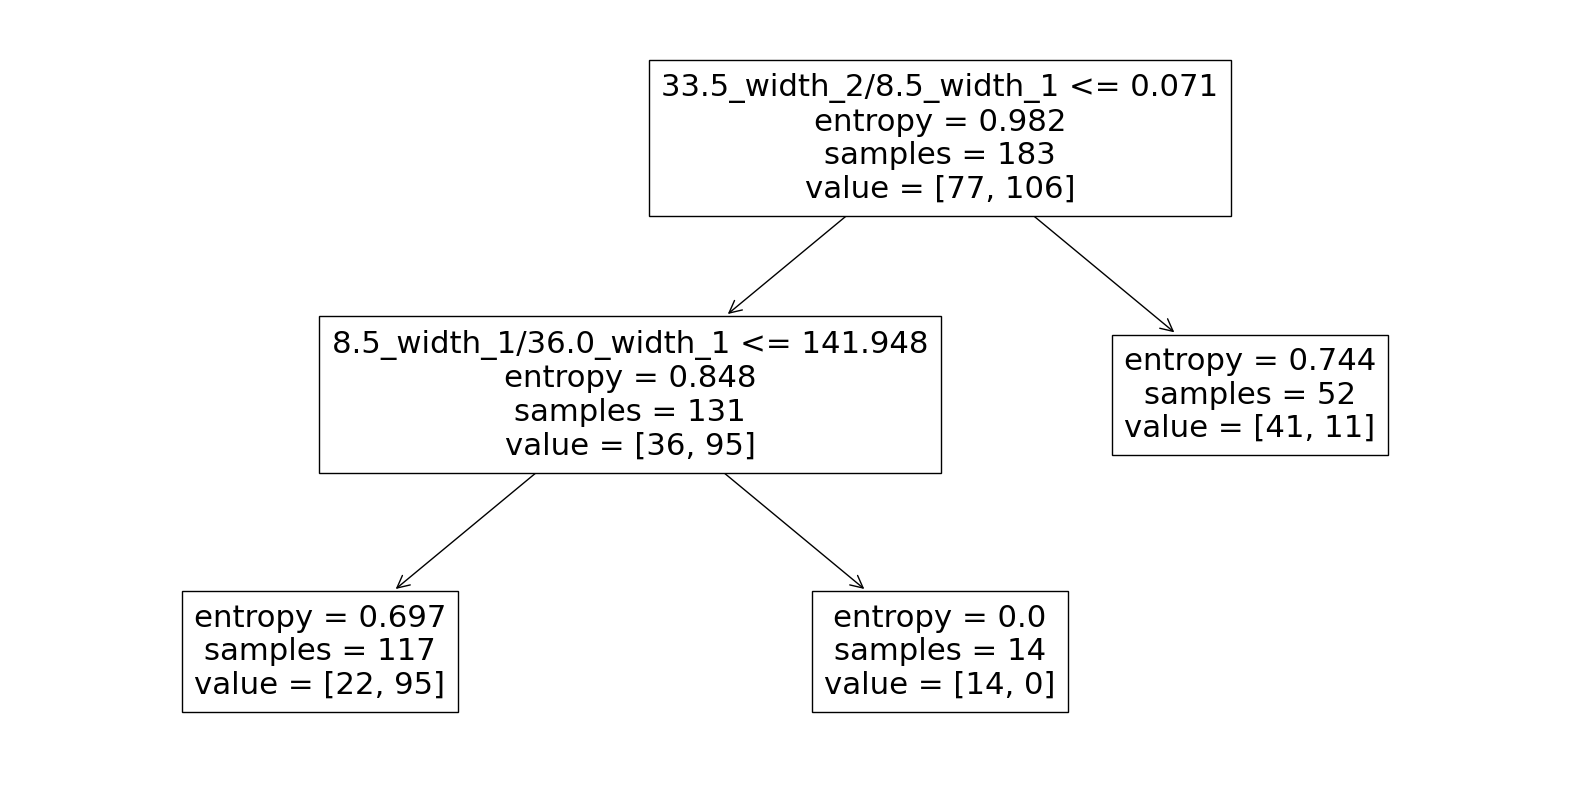

In [155]:
DT2 = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = 3)
DT2.fit(X_expt[max_preds_arr < 0.9] , y_expt[max_preds_arr < 0.9])
plot_tree(DT2, feature_names = list(X_expt.columns) )

(0.0, 1.9)

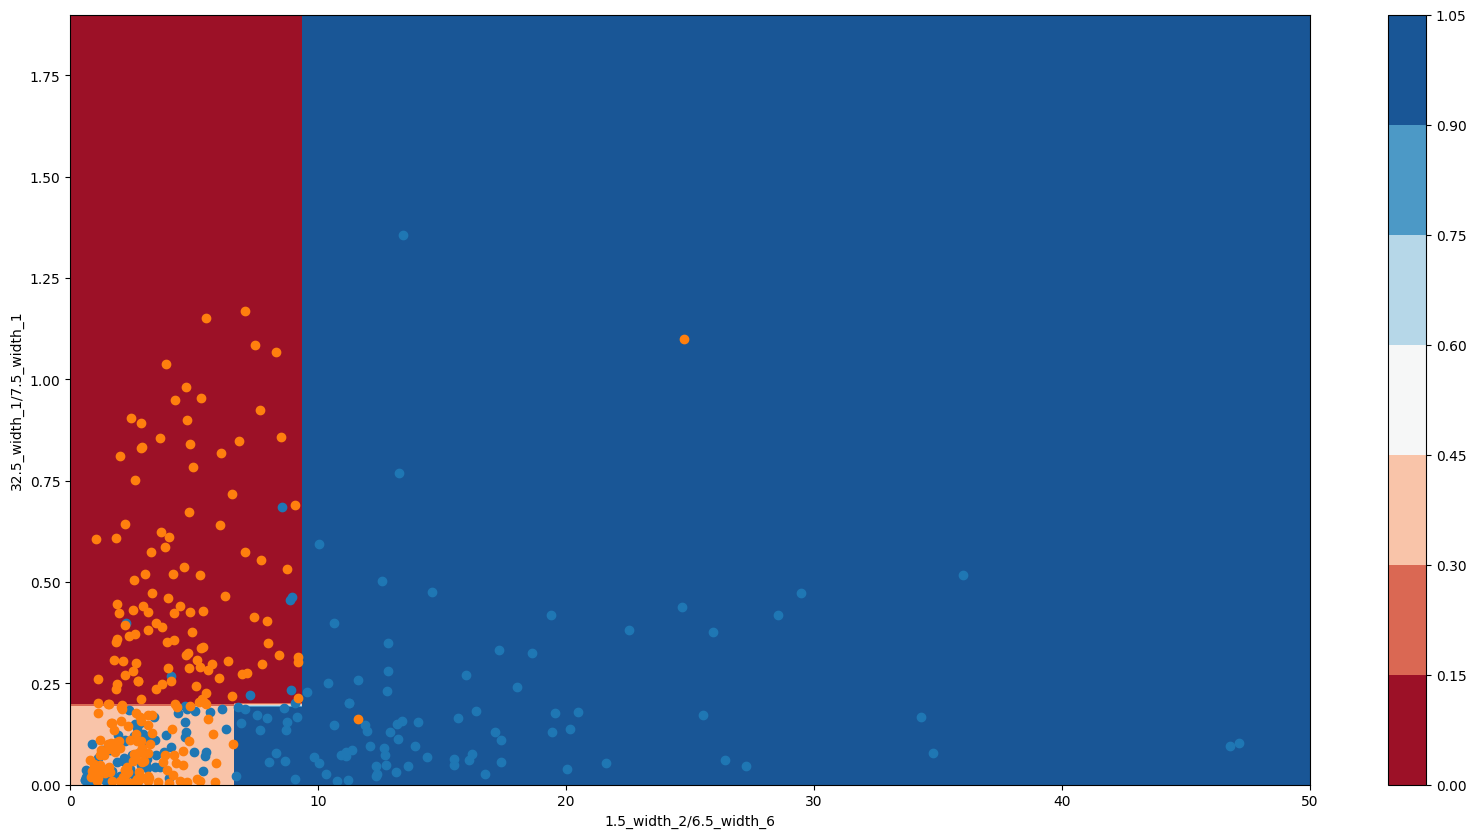

In [132]:
# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

plt.scatter(X_expt['1.5_width_2/6.5_width_6'][y_expt == 0 ].values, X_expt['32.5_width_1/7.5_width_1'][y_expt == 0 ].values)
plt.scatter(X_expt['1.5_width_2/6.5_width_6'][y_expt == 1 ].values, X_expt['32.5_width_1/7.5_width_1'][y_expt == 1].values)

plt.xlabel('1.5_width_2/6.5_width_6')
plt.ylabel('32.5_width_1/7.5_width_1')

plt.xlim(0,50)
plt.ylim(0,1.9)

#### Run Test Expts

13.668617725372314


[Text(0.5, 0.75, '4.5_width_8 <= 0.011\nentropy = 0.992\nsamples = 399\nvalue = [178, 221]'),
 Text(0.25, 0.25, 'entropy = 0.791\nsamples = 257\nvalue = [61, 196]'),
 Text(0.75, 0.25, 'entropy = 0.671\nsamples = 142\nvalue = [117, 25]')]

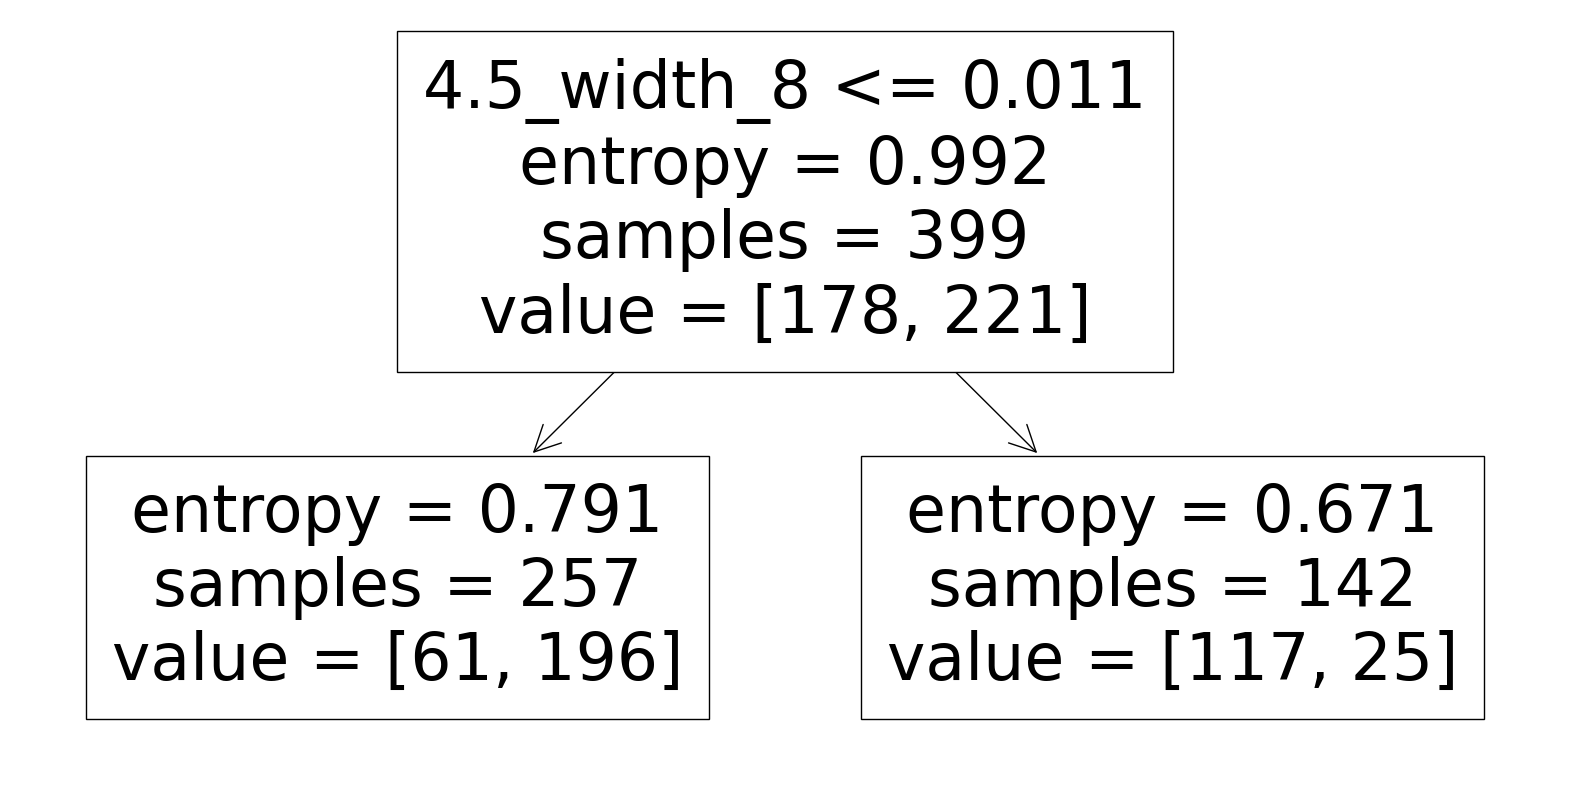

In [7]:
t1 = time.time()

X_expt = regional_dfs['Prefrontal']
DT = DecisionTreeClassifier(criterion = 'entropy', max_depth=1)

DT.fit(X_expt, y_expt)

t2 = time.time()

print(t2 -  t1 )

plot_tree(DT, feature_names = list( X_expt.columns ) )

31.395493268966675


[Text(0.4, 0.8333333333333334, '4.5_width_8 <= 0.011\nentropy = 0.992\nsamples = 399\nvalue = [178, 221]'),
 Text(0.2, 0.5, 'entropy = 0.791\nsamples = 257\nvalue = [61, 196]'),
 Text(0.6, 0.5, '13.0_width_1/7.5_width_4 <= 0.057\nentropy = 0.671\nsamples = 142\nvalue = [117, 25]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.485\nsamples = 19\nvalue = [2, 17]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.347\nsamples = 123\nvalue = [115, 8]')]

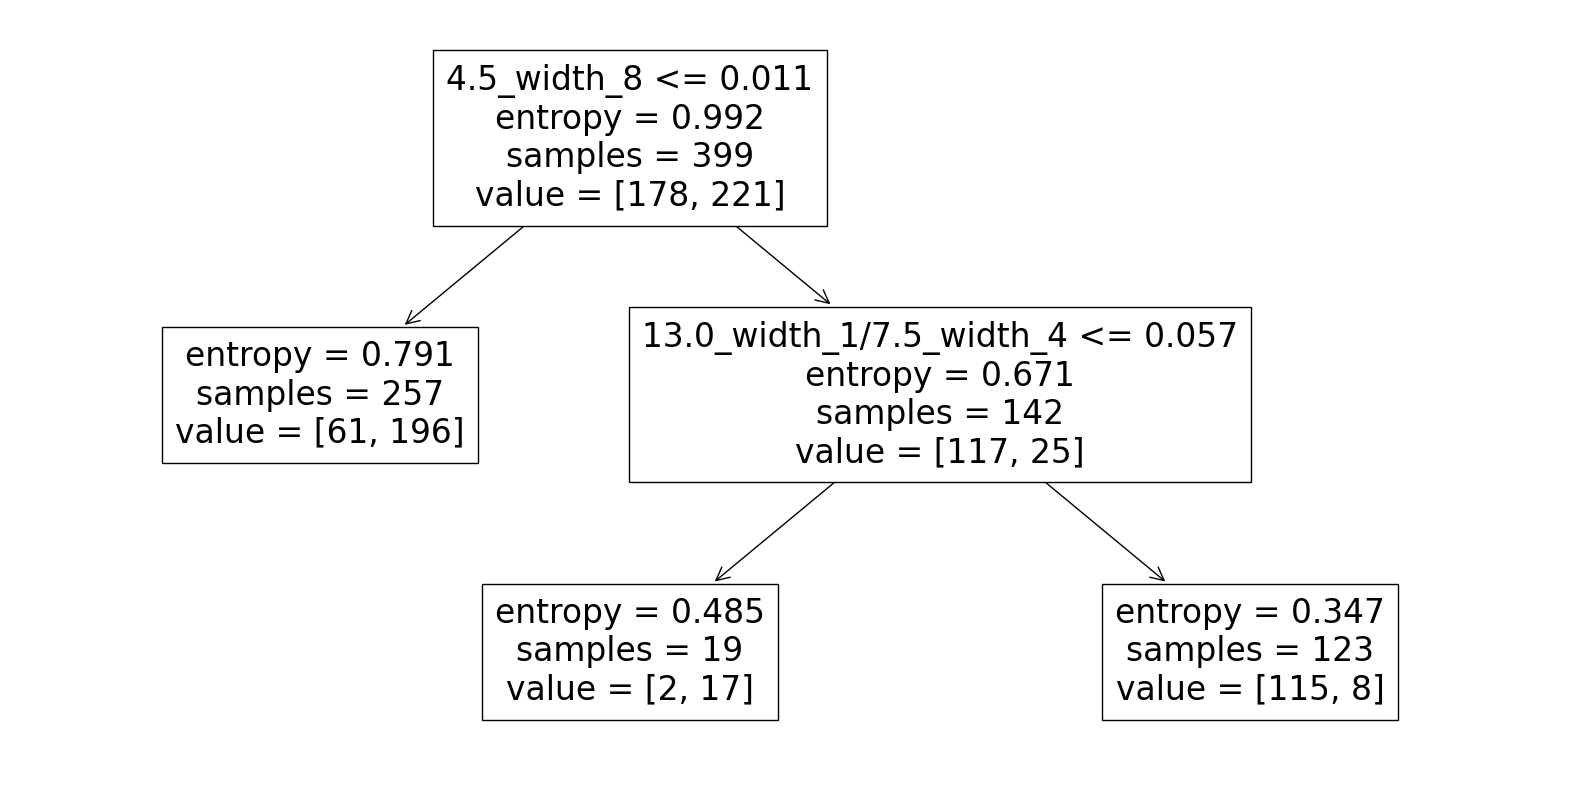

In [8]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (20,10)

t1 = time.time()

X_expt = regional_dfs['Prefrontal']
DT = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=3)

DT.fit(X_expt, y_expt)

t2 = time.time()

print(t2 -  t1 )

plot_tree(DT, feature_names = list( X_expt.columns ) )